* Spearmint for analogy reasoning
* Gaussian LDA
* Evaluate word analogy reasoning
* evalutate topic models
* find background noise
* find word pairs

# Setup

In [1]:
%matplotlib notebook

import itertools
import logging
from functools import partial

import gensim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn.cluster import *
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE

from knub.thesis.util import *
matplotlib.style.use('ggplot')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

# Evaluating strength of raw models

## Topic Models → Topic Coherence, Concept Categorization

Evaluated using Palmetto tool from **Exploring the Space of Topic Coherence Measures** paper
Values still seem low compared to example values from the paper

In [3]:
df_tc_results = pnd.DataFrame([
        ("topic.full.alpha-1-100.256-400.model", 0.469500859375, 0.00617111859067, 0.6463414634146342),
        ("topic.16-400.model", 0.43805875, 0.00390183951094, 0.5975609756097561),
        ("topic.256-1000.model", 0.473455351563, 0.00635883046394, 0.5853658536585366),
        ("topic.64-400.model", 0.45327734375, 0.00385141007263, 0.6341463414634146),
        ("topic.256-400.model", 0.46836359375, 0.00599032492068, 0.5731707317073171),
        ("topic.full.fixed-vocabulary.alpha-1-100.256-400.model", 0.468437070312, 0.00562772603243, 0.5975609756097561),
        ("topic.full.256-400.model", 0.472498945313, 0.00624853749772, 0.5975609756097561),
        ("topic.256-600.model", 0.478640273437, 0.00685787139094, 0.5609756097560975)
    ], 
    columns=["Topic model parameters", "TC_mean", "TC_var", "CC_purity"])

In [4]:
df_tc_results.sort_values(by="TC_mean", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
7,topic.256-600.model,0.478640,0.006858,0.560976
2,topic.256-1000.model,0.473455,0.006359,0.585366
6,topic.full.256-400.model,0.472499,0.006249,0.597561
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
5,topic.full.fixed-vocabulary.alpha-1-100.256-40...,0.468437,0.005628,0.597561
4,topic.256-400.model,0.468364,0.005990,0.573171
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561


In [5]:
df_tc_results.sort_values(by="CC_purity", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561
5,topic.full.fixed-vocabulary.alpha-1-100.256-40...,0.468437,0.005628,0.597561
6,topic.full.256-400.model,0.472499,0.006249,0.597561
2,topic.256-1000.model,0.473455,0.006359,0.585366
4,topic.256-400.model,0.468364,0.005990,0.573171
7,topic.256-600.model,0.478640,0.006858,0.560976


In [6]:
df_tc_results.sort_values(by="TC_var", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
7,topic.256-600.model,0.478640,0.006858,0.560976
2,topic.256-1000.model,0.473455,0.006359,0.585366
6,topic.full.256-400.model,0.472499,0.006249,0.597561
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
4,topic.256-400.model,0.468364,0.005990,0.573171
5,topic.full.fixed-vocabulary.alpha-1-100.256-40...,0.468437,0.005628,0.597561
1,topic.16-400.model,0.438059,0.003902,0.597561
3,topic.64-400.model,0.453277,0.003851,0.634146


## Word Embeddings → Analogy Reasoning

Using the question word data set (~19k questions) from **Efficient Estimation of Word Representations in Vector Space** (word2vec).
Also, currently running Spearmint optimization to look for better embeddings.

In [7]:
pnd.set_option("display.max_colwidth", 100)

In [8]:
df_tc_results = pnd.DataFrame([
        ("embedding.skip-gram.size-200.window-5.negative-5.model", 0.481221858371),
        ("embedding.cbow.size-200.window-5.model", 0.416547277937),
        ("embedding.google.size-300", 0.735878018829),
    ], 
    columns=["Word Embeddings", "Analogy_Reasoning"])

df_tc_results.sort_values(by="Analogy_Reasoning", ascending=False)

,Word Embeddings,Analogy_Reasoning
2,embedding.google.size-300,0.735878
0,embedding.skip-gram.size-200.window-5.negative-5.model,0.481222
1,embedding.cbow.size-200.window-5.model,0.416547


# Preprocessing

In [9]:
MODEL = "../models/topic-models/topic.full.alpha-1-100.256-400.model"

In [10]:
print "Load vectors"
vectors = load_skip_gram()
model = TopicModelLoader(MODEL, vectors)
print "Load topic probs"
df_topic_probs_full = model.load_topic_probs()
print "Load topics"
df_topics = model.load_topics()
print "Load topic similars"
df_topic_similars = model.load_all_topic_similars()

Load vectors
Load topic probs
Load topics
Load topic similars


# Topic Probs Analysis

In [11]:
df_topic_probs = df_topic_probs_full[df_topic_probs_full["word"].apply(lambda w: w in model.topic_words)].copy()
df_topic_probs["stddev"] = df_topic_probs[model.prob_columns].std(axis=1)

In [12]:
df_topic_probs.head(3)[model.prob_columns].mean(axis=1)*256

1    1.0
2    1.0
5    1.0
dtype: float64

### Highest std. dev.

In [13]:
df_topic_probs.sort_values(by="stddev", ascending=False).head(10)[["word", "stddev"]]

,word,stddev
97299,gmina,0.062500
15107,cerambycidae,0.062500
5051,forewings,0.062341
12297,rabbi,0.061799
5040,moth,0.061736
26868,nascar,0.061622
12185,nigerian,0.061617
97298,voivodeship,0.061585
29709,kuala,0.061550
30707,nhl,0.061477


### Lowest std. dev.

In [14]:
df_topic_probs.sort_values(by="stddev", ascending=True).head(10)[["word", "stddev"]]

,word,stddev
169,one,0.002358
188,also,0.002516
302,two,0.002998
430,first,0.003318
354,known,0.003707
483,time,0.004129
680,part,0.004133
412,later,0.004259
2844,however,0.004622
2167,early,0.004699


# Correlation TM similarity and WE similarity

### Ten most similar words for each top-10-topic word

 Topic model similarity evaluated using different probability distribution similarity measures (evaluated on the normalized word-topic distributions):
 
 * [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
 * Hellinger distance
 * Bhattacharyya coefficient

In [15]:
df_topic_similars.head()

,word,similar_word,tm_sim_max,tm_sim_sum,tm_sim_bhattacharyya,tm_sim_hellinger,tm_sim_jensen-shannon,we_sim
0,military,staffs,0.912480,0.558798,0.766800,0.517092,0.118427,0.318163
1,military,army,0.912530,0.562705,0.768054,0.518392,0.119736,0.608158
2,military,forces,0.916243,0.572355,0.768518,0.518874,0.133331,0.571750
3,military,peacetime,0.916459,0.580579,0.786892,0.538363,0.141890,0.615062
4,military,defence,0.919340,0.603073,0.789961,0.541700,0.166720,0.493413


### Correlation between TM and WE similarity

In [16]:
model.sim_functions = ["max", "sum", "bhattacharyya", "hellinger", "jensen-shannon"]

sim_corrs_spearman = []
sim_corrs_pearson = []
for sim_function in model.sim_functions:
    corr_spearman = df_topic_similars[["tm_sim_%s" % sim_function, "we_sim"]].corr("spearman").ix[0,1]
    corr_pearson = df_topic_similars[["tm_sim_%s" % sim_function, "we_sim"]].corr("pearson").ix[0,1]
    sim_corrs_spearman.append(corr_spearman)
    sim_corrs_pearson.append(corr_pearson)

df_tmp = pnd.DataFrame(model.sim_functions, columns=["sim_function"])
df_tmp["sim_corr_spearman"] = sim_corrs_spearman
df_tmp["sim_corr_pearson"] = sim_corrs_pearson
df_tmp

,sim_function,sim_corr_spearman,sim_corr_pearson
0,max,-0.076134,-0.043531
1,sum,0.485480,0.467992
2,bhattacharyya,0.417126,0.424787
3,hellinger,0.417126,0.412042
4,jensen-shannon,-0.349793,-0.350979


**Note: Similar results Google vectors**

### Distribution of TM similarity

<IPython.core.display.Javascript object>


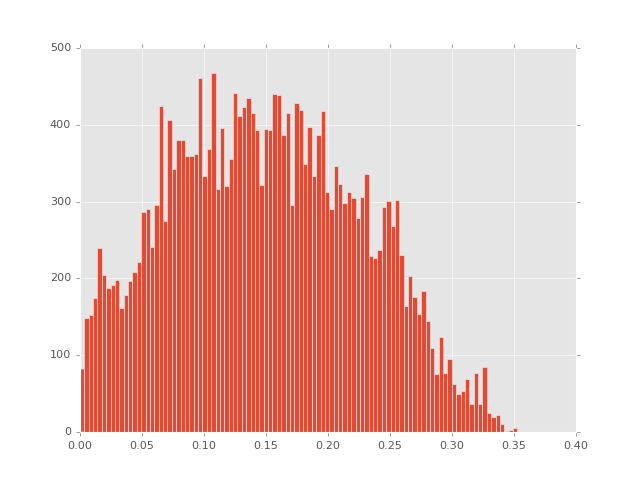

In [24]:
plt.figure()
df_topic_similars["tm_sim_jensen-shannon"].hist(bins=100)

### Distribution of WE similarity

<IPython.core.display.Javascript object>


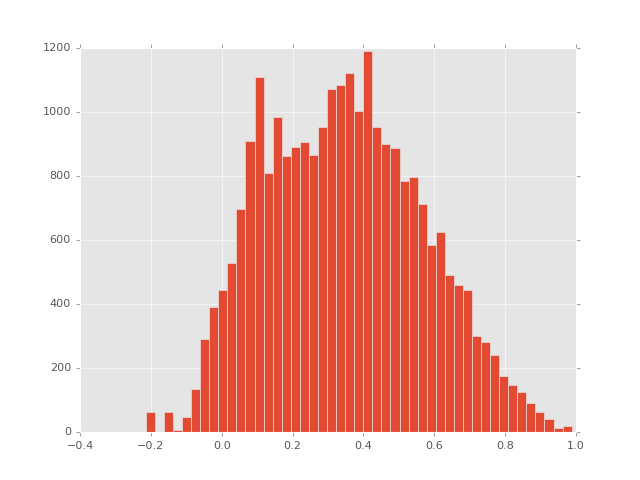

In [25]:
plt.figure()
df_topic_similars["we_sim"].hist(bins=50)

In [19]:
we_percentile = df_topic_similars["we_sim"].quantile(q=.30)
we_percentile

0.20486269730143181

In [26]:
df_tmp = df_topic_probs[["word", "stddev"]]
df_tmp.columns = ["w", "stddev"]
df_result = df_topic_similars.merge(df_tmp, left_on="similar_word", right_on="w")
del df_result["w"]
word_prob_quantile = df_result["stddev"].quantile(0.8)

### High TM similarity, low WE similarity

In [27]:
df_large_sim_diff = df_result[(df_result["we_sim"] < 0.4) & (df_result["stddev"] > 0.025)]
df_large_sim_diff.iloc[np.random.permutation(len(df_large_sim_diff))]

,word,similar_word,tm_sim_max,tm_sim_sum,tm_sim_bhattacharyya,tm_sim_hellinger,tm_sim_jensen-shannon,we_sim,stddev
1442,animal,wolf,0.939321,0.667238,0.812798,0.567332,0.032647,0.207890,0.031948
789,households,females,0.891974,0.795478,0.884133,0.659607,0.088043,0.250761,0.030429
1878,sexual,gay,0.936971,0.797510,0.884355,0.659934,0.070653,0.382602,0.049514
1852,ethiopian,kong,0.975714,0.938143,0.971565,0.831373,0.019909,0.024090,0.058594
1727,votes,elections,0.912048,0.742868,0.859900,0.625701,0.072733,0.393734,0.038664
792,households,females,0.891974,0.795478,0.884133,0.659607,0.088043,0.250761,0.030429
2042,award,contest,0.919831,0.617964,0.838838,0.598550,0.207494,0.247108,0.032943
1839,medal,rank,0.786550,0.443729,0.635392,0.396173,0.053745,0.214211,0.028736
1600,constituency,liberal,0.888191,0.662749,0.801406,0.554361,0.151110,0.315658,0.027806
1717,administrative,lies,0.854209,0.611340,0.754661,0.504683,0.220641,0.114501,0.027498


### High TM similarity, high WE similarity

In [22]:
df_small_sim_diff = df_result[(df_result["we_sim"] > 0.8) & (df_result["stddev"] > 0.025)]
df_small_sim_diff.iloc[np.random.permutation(len(df_small_sim_diff))]

,word,similar_word,tm_sim_max,tm_sim_sum,tm_sim_bhattacharyya,tm_sim_hellinger,tm_sim_jensen-shannon,we_sim,stddev
2023,drugs,drug,0.961754,0.853085,0.964254,0.810935,0.133683,0.839987,0.029113
1599,conservative,liberal,0.904876,0.738297,0.892804,0.672592,0.164209,0.886612,0.027806
1520,locomotives,locomotive,0.985610,0.978550,0.994476,0.925679,0.018198,0.844325,0.059194
1594,liberal,conservative,0.904876,0.746874,0.888088,0.665467,0.141828,0.886612,0.028347
635,bass,guitar,0.908315,0.687827,0.840264,0.600330,0.119666,0.915111,0.030964
638,bishop,archbishop,0.904739,0.834983,0.931139,0.737585,0.044528,0.898991,0.038320
1527,buenos,aires,0.995521,0.994942,0.999415,0.975809,0.006205,0.899445,0.060902
1545,francisco,diego,0.934812,0.747282,0.866766,0.634988,0.111047,0.921034,0.032479
2038,award,awards,0.866506,0.562245,0.735712,0.485910,0.152539,0.833322,0.037197
1965,jacques,pierre,0.953684,0.783048,0.868368,0.637188,0.113166,0.889388,0.042466


# Findings

* syntatic variations play a bigger role in WE models, example:

  **(development, developed)**: TM-sim: 0.960519 WE-SIM: 0.360895
  
  **(composed, composers)** TM-SIM: 0.973376 WE-SIM: 0.329483
  
  **(works, working)** TM-SIM: 0.969470 WE-SIM: 0.274090
* topic models are better at capturing loose relationships, such as:

  **(war, commander)** TM-SIM: 0.922352 WE-SIM: 0.187498
  
  **(living, households)** TM-SIM: 0.983162 WE-SIM: 0.207906
  
  **(county, rural)** TM-SIM: 0.882099 WE-SIM: 0.257984
  

# Concept categorization in TM and WE

Roughly the same results after using the same algorithm for both systems

In [28]:
def get_embedding_from_word_embedding(word):
    try:
        return vectors[word]
    except:
        return vectors["this"]

columns = [str(i) for i in range(256)]
def get_embedding_from_topics(word):
    df_row = df_topic_probs_full[df_topic_probs_full["word"] == word]
    assert len(df_row) == 1, "not exactly one row found: " + word + " " + len(df_row)
    return df_row[columns].iloc[0,:].tolist()

def get_df_concept(embedding_function):
    df_concept = pnd.read_csv(
        "/home/knub/Repositories/master-thesis/data/concept-categorization/battig_concept-categorization.tsv",
        sep="\t",
        header=None)
    df_concept.columns = ["word", "concept"]
    df_concept["embeddings"] = df_concept["word"].apply(embedding_function)
    return df_concept

df_we_concept = get_df_concept(get_embedding_from_word_embedding)
df_tm_concept = get_df_concept(get_embedding_from_topics)
df_tm_concept.head(2)

,word,concept,embeddings
0,dog,land-mammals,"[0.00352872698013, 2.17180189723e-08, 9.67051718033e-09, 0.0028940554259, 9.89564258889e-09, 0.0..."
1,elephant,land-mammals,"[4.18416122346e-08, 7.66164594561e-08, 0.000469006248609, 3.12245165676e-08, 3.4909680306e-08, 4..."


In [29]:
len(df_tm_concept.ix[0,"embeddings"])

256

In [30]:
from sklearn import metrics

# http://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def single_cluster_purity(df_param):
    return df_param["concept"].value_counts().max()

def calculate_purity(df_param):
    purity = float(sum([single_cluster_purity(df_cluster_group)
                        for _, df_cluster_group
                        in df_param.groupby("cluster_id")])) / len(df_param)
    return purity


def evaluate_clustering_algorithm(df_param, clustering):
    X = np.array(df_param["embeddings"].tolist())
    X_sim = metrics.pairwise.pairwise_distances(X, metric="cosine")
    # sim or not sim? PCA or not PCA?
    clusters = clustering.fit_predict(pca(X_sim, 10))
    df_param["cluster_id"] = clusters
    return calculate_purity(df_param)

In [31]:
for df_concept in [df_we_concept, df_tm_concept]:
    print "-" * 100
    for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1),
                       AgglomerativeClustering(n_clusters=10, linkage="ward"),
                       AgglomerativeClustering(n_clusters=10, linkage="complete"),
                       AgglomerativeClustering(n_clusters=10, linkage="average"),
                       AffinityPropagation(damping=0.5),
                       AffinityPropagation(damping=0.6),
                       AffinityPropagation(damping=0.7),
                       AffinityPropagation(damping=0.8),
                       AffinityPropagation(damping=0.9),
                   SpectralClustering(n_clusters=3)]:
        print clustering.__class__.__name__
        print evaluate_clustering_algorithm(df_concept, clustering)

----------------------------------------------------------------------------------------------------
KMeans
0.756097560976
AgglomerativeClustering
0.780487804878
AgglomerativeClustering
0.768292682927
AgglomerativeClustering
0.731707317073
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.670731707317
AffinityPropagation
0.670731707317
AffinityPropagation
0.707317073171
SpectralClustering
0.353658536585
----------------------------------------------------------------------------------------------------
KMeans
0.768292682927
AgglomerativeClustering
0.768292682927
AgglomerativeClustering
0.780487804878
AgglomerativeClustering
0.743902439024
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.743902439024
AffinityPropagation
0.121951219512
SpectralClustering
0.365853658537


# Word Similarity

## Similarity

In [45]:
def word_similarity(f):
    try:        
        df_sim = pnd.read_csv(MODEL + f, sep="\t")
        df_sim["embedding-sim"] = df_sim[["word1", "word2"]].apply(
            lambda x: model.get_similarity(x["word1"], x["word2"], vectors), axis=1)
        topic_sim_column = df_sim.columns[3]
        
        topic_corr     = df_sim[["human-sim", topic_sim_column]].corr("spearman").ix[0,1]
        embedding_corr = df_sim[["human-sim", "embedding-sim"]].corr("spearman").ix[0, 1]
        
        return pnd.DataFrame([[topic_corr, embedding_corr]],
                             columns=["topic_corr", "embedding_corr"],
                             index=[f])
    except Exception as e:
        return None

df_tmp = pnd.concat([word_similarity(".wordsim353-all-bhattacharyya"),
            word_similarity(".wordsim353-all-hellinger"),
            word_similarity(".wordsim353-all-jensen-shannon"),
            word_similarity(".wordsim353-all-sum"),
            word_similarity(".wordsim353-rel-bhattacharyya"),
            word_similarity(".wordsim353-rel-hellinger"),
            word_similarity(".wordsim353-rel-jensen-shannon"),
            word_similarity(".wordsim353-rel-sum"),
            word_similarity(".wordsim353-sim-bhattacharyya"),
            word_similarity(".wordsim353-sim-hellinger"),
            word_similarity(".wordsim353-sim-jensen-shannon"),
            word_similarity(".wordsim353-sim-sum")])
df_tmp.sort_values(by="topic_corr", ascending=False)

,topic_corr,embedding_corr
.wordsim353-sim-bhattacharyya,0.629259,0.743211
.wordsim353-sim-hellinger,0.629104,0.743211
.wordsim353-sim-jensen-shannon,0.626463,0.743211
.wordsim353-sim-sum,0.613472,0.743211
.wordsim353-all-bhattacharyya,0.577273,0.656986
.wordsim353-all-hellinger,0.577256,0.656986
.wordsim353-all-jensen-shannon,0.571601,0.656986
.wordsim353-all-sum,0.554150,0.656986
.wordsim353-rel-hellinger,0.526983,0.572367
.wordsim353-rel-bhattacharyya,0.526891,0.572367
